In [1]:
from abg_python.all_utils import boxcar_average
from abg_python.plot_utils import nameAxes

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities


Duplicate key in file PosixPath('/Users/agurvich/.matplotlib/stylelib/ABG_black_presentation.mplstyle'), line 9 ('axes.edgecolor : w')


In [2]:
Gmks = 6.67430 ## m3⋅kg−1⋅s−2 # e-11
Gmks *= (2) ## m3 msun^-1 s^-2 # e30
Gmks *= (3600*24) ## m3 msun^-1 day^-2
Gmks /= ((6.957)**3)# e8 e8 8
## -11 + 30 + 24 - 6 - 8 - 11
Gexoplanet = Gmks*1e-5

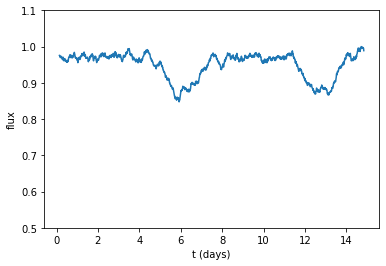

In [3]:
def trapezoid(x, tc, tau, T, delta):
    #convert variables from paper into trapezoid definition
    t1 = tc - (T + tau)/2 
    t2 = t1 + tau 
    t3 = t1 + T
    t4 = t1 + T + tau 
    
    #handle case when x is a list/array
    try: 
        iter(x)
        return [trapezoid(i, tc, tau, T, delta) for i in x]
    except:
        if x <= t1:
            return 1
        elif t1 < x <= t2: 
            return 1 - (delta/(t2 - t1))*(x - t1)
        elif t2 < x <= t3:
            return 1 - delta
        elif t3 < x <=t4:
            return 1 - delta + (delta/(t4-t3))*(x-t3)
        else:
            return 1
    
def add_planet(
    Mstar, ## solar masses
    Rstar, ## solar radii
    Rp, ## earth radii
    period, ## days
    duration, ## days
    ax=None,
    light_xs=None,
    light_ys=None,
    fname='planet_grid.pdf'):
    
    if period < 0 : period=np.abs(period)+3
        
    dt = 0.01
    if light_xs is None:
        light_xs = np.arange(0,duration,dt)#*np.random.uniform(0.2,5)
        light_ys = np.ones(light_xs.size)
        noise_flag=True
    else:
        noise_flag=False
        
    
    ## Rstar/a angular size of star
    ## Rstar/a / 2pi is the fraction of the period that is transit
    ## Rstar/a / 2pi * P is the duration of the transit
    ## Kepler's third law a^3/P^2 = GM/4pi^2
    Rp_star = Rp/109.076
    P_over_a = (4*period/(np.pi*Gexoplanet*Mstar))**(1/3)
    tau = Rp_star*P_over_a
    T = P_over_a *(Rstar-Rp_star)
    delta = (Rp_star/Rstar)**2
    
    try: period=max(2*(T+2*tau),period)
    except: import pdb; pdb.set_trace()
        
    phase_offset = np.random.uniform(0,period)
    for this_tc in light_xs[int(phase_offset/dt)::int(period/dt)]:
        dip = np.array(trapezoid(light_xs,this_tc,tau,T,delta))
        light_ys*=dip
        
    if noise_flag:
        noise = np.random.uniform(0.8,1,size=light_ys.size)
        light_ys*=noise
        light_xs,light_ys = boxcar_average(light_xs,light_ys,0.3,assign='center')
        light_ys/=np.nanmax(light_ys)
    
    if ax is not None:
        ax.plot(light_xs,light_ys)
        ax.set_ylim(0.5,1.1)
        nameAxes(ax,None,'t (days)','flux')
        
    return light_xs,light_ys

xs,ys = add_planet(
    0.3, #mstar
    0.3, #rstar
    10, #rplanet
    5,# period of orbit
    15, ## observation time
    plt.gca())

In [4]:
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [5]:
def add_sphere_to_ax(ax,radius,orbital_sep,c='b',offset_angle=0,zorder=10):
    if orbital_sep == 0:
        offset_x=offset_y=0
    else:
        offset_x = np.cos(offset_angle)*(orbital_sep)
        offset_y = np.sin(offset_angle)*(orbital_sep)


    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    """
    x = radius * np.outer(np.cos(u), np.sin(v))+offset_x
    y = radius * np.outer(np.sin(u), np.sin(v))+offset_y
    z = radius*1.25 * np.outer(np.ones(np.size(u)), np.cos(v))
    """
    #ax.plot_surface(x, y, z, color=c,zorder=zorder)

    ax.plot(offset_x,offset_y,0,'.',c=c,markersize=radius,zorder=zorder)
    
    if orbital_sep > 0:
        ax.plot(np.cos(u)*orbital_sep,np.sin(u)*orbital_sep,np.zeros(u.size),c='w',ls='--',zorder=10)

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def make_gif(
    rstar=1,
    rplanets=None,
    periods=None,
    edgeon=False,
    nframes=10,
    dir_name=None):
    
    if rplanets is None: rplanets = [1] 
    if periods is None: periods = [1] 
    
    if dir_name is None: dir_name = os.getcwd()
        

    dt = 0.005
    
    colors = ['blue','red','green','orange']
    for i in range(nframes):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        angle = 20 if not edgeon else 0
        ax.view_init(angle, 0)

        radius = 20
        orbital_sep = 300
    
        
        

    
        for rplanet,period,color in zip(
            rplanets,periods,colors):
            
            omega = 2*np.pi/period
            
            ## determine phase of planet
            offset_angle = omega*dt*i
            
            ## determine if planet should be in front of or behind the star
            if angle == 0:
                zorder = -12 if offset_angle > np.pi/2 and offset_angle < 3*np.pi/2 else 12
            else:
                zorder = 12
            
            this_orbital_sep = period**(2/3)*orbital_sep
            
            add_sphere_to_ax(
                ax,
                radius*rplanet,
                this_orbital_sep,
                offset_angle=offset_angle,
                zorder=zorder,
                c=color)
            
            ## handle if star is too big
            if 3*radius*rstar > this_orbital_sep: rstar=this_orbital_sep*0.9/radius/3

        add_sphere_to_ax(ax,3*radius*rstar,0,c='y',zorder=4)
        


        # Make data

        ax.set_xlim(-orbital_sep*1.15,orbital_sep*1.15)
        ax.set_ylim(-orbital_sep*1.15,orbital_sep*1.15)
        ax.set_zlim(-orbital_sep*1.15,orbital_sep*1.15)

        ax.axis('off')
        ax.set_facecolor('k')
        fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
        fig.set_size_inches(6,6)
        axisEqual3D(ax)

        fig.savefig(os.path.join(dir_name,'frame_%03d.png'%i))
        nameAxes(plt.gca(),None,None,None,supertitle='')
        plt.close(fig)

$L = m_* R_*^2 -> Flux(R_{sphere}) m_* R_*^2 / 4 \pi R_{sphere}^2$

$Flux_\oplus = m_\odot R_\odot ^2 /4 \pi (s_\oplus)^2$

$L_\oplus = Flux_\oplus*R_\oplus^2$

$L_\oplus = \sigma T_\oplus^4$

$ T_\oplus^4 \propto  R_\oplus^2 s_\oplus^{-2} m_\odot R_\odot^2$

$ T_\oplus^4 \propto  R_\oplus^2 (P_\oplus)^{-4/3} m_\odot R_\odot^2$

In [33]:
earth_temperature = 300
## L scales w/ M Rstar^2; irradiance scales w/ 1/separation^2 * planet_radius**2


mstars = [
    1, 
    0.4, 
    1, 
    0.1,
    0.1,
    0.1,
    1,
    2,
    1]
rstars = [
    0.5, 
    0.2, 
    0.5,
    0.5,
    0.7,
    0.5,
    1,
    0.5,
    3]
rplanets = [
    15.0, 
    3.0, 
    30.0,
    2.0,
    30.0,
    20.0,
    5,
    10.0,
    50.0]
periods = [
    5, 
    2, 
    10, 
    10,
    20,
    10,
    10,
    1,
    10]

observation_time = 30

## for making gifs
default_rstar = 0.5
default_rplanet = 10
default_period = 10

## 4 different group's worth of grids/gifs
for k in range(10):
    subtitles = []
    
    ## initialize the figure
    fig,axs = plt.subplots(nrows=3,ncols=3,sharex=False,sharey=False)
    
    ## shuffle the planets around because we don't want the kids getting wise
    js = np.arange(9)#np.random.choice(np.arange(9),9,replace=False)
    
    ## loop through each qualitative case study
    for i in range(len(axs.flatten())):
        this_mstar = mstars[i]+np.random.random() #mstar
        this_rstar = rstars[i]+np.random.random()*0.3#rstar
        ax = axs.flatten()[js[i]]
        
        light_xs,light_ys = None,None

        gif_rplanets = []
        gif_periods = []
        
        n_planets= 1 + np.random.randint(0,3)
        subtitle = ""
        old_i = i
        for n in range(n_planets):
            ## take the hand-picked parameters above and nudge them a bit
            if n >= 1:
                i = np.random.randint(9)
                
            this_rplanet = rplanets[i]+np.random.random()*4-2 #rplanet
            this_period = periods[i]+np.random.random()*4-2# period of orbit

            this_separation = (this_period/365.25)**(2/3) ## in au
            this_temperature = (
                earth_temperature * 
                (this_mstar * 
                this_rstar**2 * 
                11**2 * this_separation**(-2))**0.25)
        
            if this_period < 0: this_period = 3+np.abs(this_period)


            ## add the light-curve of this planet
            light_xs,light_ys = add_planet(
                this_mstar,
                this_rstar,
                this_rplanet,
                this_period,
                observation_time,
                ax=None,
                light_xs=light_xs,
                light_ys=light_ys) 
        

            ## what are we gonna label this guy for our answer key
            subtitle += ('\nMs (M$_\odot$) | Rs (R$_\odot$)| Rp (R$_\oplus$) | P (days) | T (K) | sep (AU) \n'+
                f'{this_mstar:.2f}       | {this_rstar:.2f}      | {this_rplanet:.2f}    | {2*this_period:.2f} | {this_temperature:.0f} | {this_separation:.3f}')
            
            ## stash info for making a gif:
            gif_rplanets+=[this_rplanet/default_rplanet]
            gif_periods+=[this_period/default_period]
            
        i = old_i
        subtitles+=[subtitle]
        
        ax.plot(light_xs,light_ys,c='black')
        ax.set_ylim(0.4,1.1)
        nameAxes(ax,None,'t (days)','flux')
        
        ## now we have to make a gif(s) for this planet system
        this_dir_name = "gifs/group_%d_planet_%d"%(k,i)
        
        if not os.path.isdir(this_dir_name):
            os.makedirs(this_dir_name)

        do_gif = True
        if do_gif:
            make_gif(
                this_rstar/default_rstar,
                gif_rplanets,
                gif_periods,
                dir_name=this_dir_name,
                nframes=200)
        
    ## format the final output figure
    fig.set_size_inches(18,18)
    fig.set_dpi(120)
    fig.set_facecolor('white')
    
    ## save without the labels
    fig.savefig("planet_grids/planet_grid_group_%d.pdf"%k)
    for i in range(len(axs.flatten())):
        subtitle=subtitles[i]
        ax = axs.flatten()[js[i]]
        nameAxes(ax,None,None,None,subtitle=subtitle)

        ## save with the labels
    fig.savefig("planet_grids/ann_planet_grid_group_%d.pdf"%k)
    plt.close(fig)

##### 